# Homework 7

#### Sitong Ju
#### USC ID: 8791155953
#### email: sitongju@usc.edu

In [ ]:
# connect to colab gpu
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec  4 07:44:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Generative Models for Text

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import glob




### 1(c)i. Concatenate your text files to create a corpus of Russell’s writings.




In [ ]:
#local_dir = '/data/*.txt'
#drive_dir = '/content/drive/My Drive/Colab_Notebooks/'
drive_dir = '../data/'
files_list = glob.glob(drive_dir + '*.txt')
files_list

['/content/drive/My Drive/Colab_Notebooks/TAM.txt',
 '/content/drive/My Drive/Colab_Notebooks/OKEWFSMP.txt',
 '/content/drive/My Drive/Colab_Notebooks/TAMatter.txt',
 '/content/drive/My Drive/Colab_Notebooks/THWP.txt',
 '/content/drive/My Drive/Colab_Notebooks/TPP.txt',
 '/content/drive/My Drive/Colab_Notebooks/AIIMAT.txt',
 '/content/drive/My Drive/Colab_Notebooks/MLOE.txt']

In [ ]:
def readFile(path):
    with open(f, encoding='ascii', errors='ignore') as myfile:
        corpus = myfile.read()
    corpus = corpus.lower()
    return corpus

file0 = readFile(files_list[0])
file1= readFile(files_list[1])
file2 = readFile(files_list[2])
file3 = readFile(files_list[3])
file4 = readFile(files_list[4])
file5 = readFile(files_list[5])
file6 = readFile(files_list[6])
corpus = [file0, file1, file2, file3, file4, file5, file6]

In [ ]:
file0[:1000]

'mysticism and logic and other essays\n\n\n\n\ni\n\nmysticism and logic\n\n\nmetaphysics, or the attempt to conceive the world as a whole by means\nof thought, has been developed, from the first, by the union and\nconflict of two very different human impulses, the one urging men\ntowards mysticism, the other urging them towards science. some men\nhave achieved greatness through one of these impulses alone, others\nthrough the other alone: in hume, for example, the scientific impulse\nreigns quite unchecked, while in blake a strong hostility to science\nco-exists with profound mystic insight. but the greatest men who have\nbeen philosophers have felt the need both of science and of mysticism:\nthe attempt to harmonise the two was what made their life, and what\nalways must, for all its arduous uncertainty, make philosophy, to some\nminds, a greater thing than either science or religion.\n\nbefore attempting an explicit characterisation of the scientific and\nthe mystical impulses, i wil

### 1(c)ii. Use a character-level representation for this model by using extended ASCII that has N = 256 characters. Each character will be encoded into a an integer using its ASCII code. Rescale the integers to the range [0, 1], because LSTM uses a sigmoid activation function. LSTM will receive the rescaled integers as its input.

In [ ]:
chars = []
for n in corpus:
    chars.extend(list(set(set(n))))

chars = sorted(list(set(chars)))
char_dict = dict((c, i) for i, c in enumerate(chars))
int_dict = dict((i, c) for i, c in enumerate(chars))

### 1(c)iv. Inputs to the network will be the first W −1 = 99 characters of each sequence, and the output of the network will be the Wth character of the sequence. Basically, we are training the network to predict each character using the 99 characters that precede it. Slide the window in strides of S = 1 on the text. For example, if W = 5 and S = 1 and we want to train the network with the sequence ABRACADABRA, The first input to the network will be ABRA and the corresponding output will be C. The second input will be BRAC and the second output will be A, etc.

In [ ]:
for n in corpus:
    windowsize = 100
    input_sequence = []
    output_sequence = []

    input_temp = []
    output_temp = []
    for w in range(0, len(n)-windowsize+1, 1):
        seqIn = n[w:w+windowsize-1]
        seqOut = n[w+windowsize-1]

        input_temp.append([char_dict[c] for c in seqIn])
        output_temp.append(char_dict[seqOut])

    input_sequence.extend(input_temp)
    output_sequence.extend(output_temp)



In [ ]:
input_sequence = np.reshape(input_sequence, (len(input_sequence), windowsize-1, 1))
print(input_sequence.shape)

# normalize
input_sequence = input_sequence / float(len(chars))

(412127, 99, 1)


### 1(c)v. Note that the output has to be encoded using a one-hot encoding scheme with N = 256 (or less) elements. This means that the network reads integers, but outputs a vector of N = 256 (or less) elements.

In [ ]:
output_sequence = np_utils.to_categorical(output_sequence)

### 1(c)vi. - x. Single layer LSTM

In [ ]:
# define the LSTM model
LSTM_model = Sequential()
LSTM_model.add(LSTM(256, input_shape=(input_sequence.shape[1], input_sequence.shape[2])))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(output_sequence.shape[1], activation='softmax'))
print(LSTM_model.summary())

LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam')

filepath = drive_dir + "./LSTMweights/weights-improvement-{epoch:02d}-{loss:.2f}-bigger.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 57)                14649     
                                                                 
Total params: 278,841
Trainable params: 278,841
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
LSTM_model.fit(input_sequence, output_sequence, epochs=30, batch_size=64, callbacks=callbacks_list)

Epoch 1/30
6438/6440 [============================>.] - ETA: 0s - loss: 2.8117
Epoch 00001: loss improved from inf to 2.81176, saving model to /Users/changhsinyu/Desktop/INF552Homework6/LSTMweights/weights-improvement-01-2.8118-bigger.hdf5
6440/6440 [==============================] - 71s 11ms/step - loss: 2.8118
Epoch 2/30
6440/6440 [==============================] - ETA: 0s - loss: 2.6340
Epoch 00002: loss improved from 2.81176 to 2.63403, saving model to /Users/changhsinyu/Desktop/INF552Homework6/LSTMweights/weights-improvement-02-2.6340-bigger.hdf5
6440/6440 [==============================] - 70s 11ms/step - loss: 2.6340
Epoch 3/30
6439/6440 [============================>.] - ETA: 0s - loss: 2.5014
Epoch 00003: loss improved from 2.63403 to 2.50134, saving model to /Users/changhsinyu/Desktop/INF552Homework6/LSTMweights/weights-improvement-03-2.5013-bigger.hdf5
6440/6440 [==============================] - 69s 11ms/step - loss: 2.5013
Epoch 4/30
6440/6440 [============================

### 1(c)xi. Use the network with the best weights to generate 1000 characters, using the following text as initialization of the network:
There are those who take mental phenomena naively, just as they would physical phenomena. This school of psychologists tends not to emphasize the object.

In [ ]:
text_init = 'There are those who take mental phenomena naively, just as they would physical phenomena. This school of psychologists tends not to emphasize the object.'

generate = [char_dict[c] for c in text_init[-99:].lower()]

for i in range(1000):
    seq = np.reshape(generate, (1, len(generate), 1))
    seq = seq / float(len(chars))
    pred_char = LSTM_model.predict(seq, verbose=0)
    ind = np.argmax(pred_char)
    text_init += int_dict[ind]
    generate.append(ind)
    generate = generate[1:len(generate)]

print(text_init)

There are those who take mental phenomena naively, just as they would physical phenomena. This school of psychologists tends not to emphasize the object. and the seeendi of the somet ay in the semeei of the somet oy to ae aeletved by the sometian areene of the somet ay in a cirtance oo the somethsn oe the porsibieit of the somet oy to ae aeletved by the sometian are the same tiree ir the some thing in the some peanines of the porsible oot seem to be a centein tore things of the somet oy to ae aeletved by the sometisn oe the porsibieit of the somet oy to ae aeletved by the sometian areene of the somet ay in a cirtance oo the somethsn oe the porsibieit of the somet oy to ae aeletved by the sometian are the same tiree ir the some thing in the some peanines of the porsible oot seem to be a centein tore things of the somet oy to ae aeletved by the sometisn oe the porsibieit of the somet oy to ae aeletved by the sometian areene of the somet ay in a cirtance oo the somethsn oe the porsibieit 

# 2. (Deep) CNNs for Image Colorization

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.color import rgb2gray
from keras.utils import np_utils
from keras.callbacks import Callback

import tensorflow as tf
import tensorflow.keras.backend as k
from tensorflow.keras.layers import Activation
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

### 2(b) From the train and test dataset, extract the class birds. We will focus on this class, which has 6000 members.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [ ]:
# find bird samples
bird_train_index, _ = np.where(y_train == 2)
bird_test_index, _ = np.where(y_test == 2)

bird_x_train = x_train[bird_train_index]
bird_y_train = y_train[bird_train_index]
bird_x_test = x_test[bird_test_index]
bird_y_test = y_test[bird_test_index]

bird_x = np.concatenate([bird_x_train, bird_x_test])
bird_y = np.concatenate([bird_y_train, bird_y_test])

In [ ]:
bird_x.shape

(6000, 32, 32, 3)

### 2(c) Those 6000 images have 6000 × 32 × 32 pixels. Choose at least 10% of the pixels randomly. It is strongly recommended that you choose a large number or all of the pixels. You will have between P = 614400 and P = 6144000 pixels. Each pixel is an RGB vector with three elements.

In [ ]:
pct = 0.1
#numPix = bird_x.shape[0] * bird_x.shape[1] * bird_x.shape[2]
pix_num = 6000 * 32 * 32
pix_random_num = int(pix_num * pct)

random_index = np.random.choice(pix_num, pix_random_num)
img_index = [i // 1024 for i in random_index]
row_index = [i % 1024 // 32 for i in random_index]
col_index = [i % 1024 % 32 for i in random_index]
pix_index = (img_index, row_index, col_index)
selected_pix = bird_x[pix_index]
print('Ndarray of selected pixels: ', selected_pix.shape)
#print(selected_pix[:10])

Ndarray of selected pixels:  (614400, 3)


### 2(d) Run k-means clustering on the P vectors using k = 4. The centers of the clusters will be your main colors. Convert the colored images to k-color images by converting each pixel’s value to the closest main color in terms of Euclidean distance. These are the outputs of your network, whose each pixel falls in one of those k classes.

In [ ]:
image_kmeans = KMeans(n_clusters=4, random_state=0).fit(selected_pix) 
cluscenter = image_kmeans.cluster_centers_.astype(np.uint8())

In [ ]:
cluscenter

array([[207, 212, 212],
       [ 48,  49,  38],
       [156, 156, 136],
       [109, 108,  83]], dtype=uint8)

In [ ]:
# A suggestion would be Navy = (0,0,128), Red =( 230, 25, 75), Mint = (170, 255, 195), and White = (255, 255, 255).

# set main colors
image_kmeans.cluster_centers_ = np.array([[0,0,128],
                                    [230,25,75],
                                    [170,255,195],
                                    [55,255,255]]).astype(np.float)


birds_in_kcolor = bird_x.reshape((-1, 3))

#birds_in_kcolor_double = np.array(birds_in_kcolor, dtype=np.double)

# converting each pixel’s value to the closest main color
#def str2float(lst):
#    for num in lst:
#        num = float(num)
#    return lst
#birds_in_kcolor = birds_in_kcolor.tolist()
#birds_in_kcolor = list(map(str2float,birds_in_kcolor))

color_index = image_kmeans.predict(birds_in_kcolor)

for i in range(birds_in_kcolor.shape[0]):
  birds_in_kcolor[i] = np.copy(image_kmeans.cluster_centers_[color_index[i]])

birds_in_kcolor = np.reshape(birds_in_kcolor, bird_x.shape)
print(birds_in_kcolor.shape)

(6000, 32, 32, 3)


### 2(e) Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32 × 32 × 1 images from the original 32 × 32 × 3 images. The grayscale images are inputs of your network.

In [ ]:
grayscale = np.expand_dims(rgb2gray(bird_x), axis=-1)

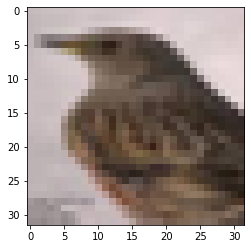

In [ ]:
plt.imshow(bird_x[2])

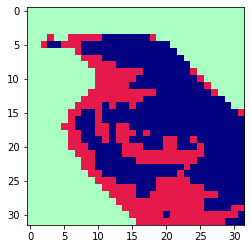

In [ ]:
plt.imshow(birds_in_kcolor[2])

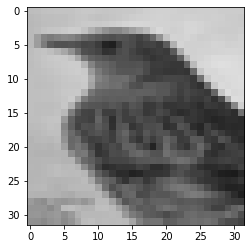

In [ ]:
plt.imshow(np.stack((grayscale[2, :, :, 0], ) * 3, axis=-1), cmap='gray')